## > Import libraries

In [ ]:
## Install and Import packages
# !pip install nolds
import nolds
import numpy as np
import pandas as pd
from scipy.io import loadmat
from tabulate import tabulate
from sklearn import preprocessing
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

In [ ]:
!git clone https://github.com/CSchoel/nolds.git

Cloning into 'nolds'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 1814 (delta 204), reused 222 (delta 131), pack-reused 1517
Receiving objects: 100% (1814/1814), 862.68 KiB | 9.92 MiB/s, done.
Resolving deltas: 100% (1211/1211), done.


## > Mount Drive

In [ ]:
## Mounting Google Drive2
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## > Import Data

In [ ]:
## Import data
img = loadmat('/content/drive/My Drive/Major_Project/Data/Indian_pines_corrected.mat')
img_gt = loadmat('/content/drive/My Drive/Major_Project/Data/Indian_pines_gt.mat')
img = img['indian_pines_corrected']
img_gt = img_gt['indian_pines_gt']
height, width, bands = img.shape[0], img.shape[1], img.shape[2]

#reshape data to 2-D array and normalize the reflectance values
img = np.reshape(img, [height*width, bands])
img_gt = np.reshape(img_gt, [height*width,])
img = preprocessing.normalize(img.astype('float32'))
num_classes = len(np.unique(img_gt))

print("Number of Classes: ", num_classes)

Number of Classes:  17


In [ ]:
#store indices of each class in a list of lists (ignoring the background class label 0)
class_dist = [] 
for i in range(1, num_classes):
    #fetch indices corresponding to class i 
    class_index = np.nonzero(img_gt == i)[0].tolist()
    #append the obtained list as an item to the main list 
    class_dist.append(class_index) 

## > Main - Classwise Pixel

In [ ]:
## Main - Find optimal Dimension - Supervised

#picking the first pixel from each  class and fetch in img
idx_list = [class_dist[i][0] for i in range(len(class_dist))]
x_all = img[idx_list,:]
#should be equal to [num_classes-1 x bands]
print("X_all shape: ", x_all.shape)

#Initialize info storing table
table = [] 
#Initialize diff storing 3-D array - initialize difference storage var to 1 as to act as +inf for change in FD
diff = np.arange(bands*bands*num_classes*1.0).reshape((bands, bands, num_classes))*0 + 1 

#setting optimal dimension as 5. We will inspect the plot obtained and then come here again to change the value.
for k in range(len(class_dist)):
    opt_dim = 5
    x = x_all[k,:]
    table.append([ k, 0, 0, 0])
    table.append([ k, 0, 0, 0])
    #Iterating after removal of one band with min Fractal change
    for i in range(bands-opt_dim):
        #Iterating to find band with min Fractal change
        for j in range(bands-i):
            #find FD
            h = nolds.corr_dim(x,1) 
            #deleting a band
            x1 = np.delete(x, j)
            #sanity check
            # print("X shape: ", x.shape, " X1 shape: ", x1.shape)
            #find partial FD
            h1 = nolds.corr_dim(x1,1)
            #find absolute difference between FD and partial FD 
            diff[i,j,k] = abs(h1-h) 

        #compute index of min difference in FD and partial FD  
        min_index_col = np.argmin(diff[i,:,k], axis=0) 
        #Store details in info table
        table.append([ i, diff[i,min_index_col,k], min_index_col, x.shape])
        #sanity checks
        # print(x.shape)
        # print(min_index_col)
        #reset x after deleting band causing min change in FD or having highest correlation
        x = np.delete(x, min_index_col)

    


## Main - Find optimal Dimension - Supervised

#picking the first pixel from each  class and fetch in img
idx_list = [class_dist[i][0] for i in range(len(class_dist))]
x_all = img[idx_list,:]
#should be equal to [num_classes-1 x bands]
print("X_all shape: ", x_all.shape)

#original fractal dimension for sample pixel
h = nolds.corr_dim(x, 1, debug_plot=True)
x1 = np.delete(x, j)
h1 = nolds.corr_dim(x1, 1, debug_plot=True)
print("Original SRC dimension: ", x.shape)
print("Original Fractal Dimesion of SRC: ", h)

#Initialize info storing table
table = [] 
#array for the sequential FD plot - FD vs #attributes considered
FD_plot = []
#Initialize diff storing 2-D array - initialize difference storage var to 1 as to act as +inf for change in FD
diff = np.arange(bands*bands*1.0).reshape((bands, bands))*0 + 1 
#store matrix- x[i,j] denote the fractal dimension in the i'th iteration after removing the j'th band in x(updated one)
x1_matrix = np.arange(bands*bands*1.0).reshape((bands, bands))*0 + 1 
#setting optimal dimension as 5. We will inspect the plot obtained and then come here again to change the value.
opt_dim = 5

#iterating for each class
for k in range(len(class_dist)):

    #Iterating after removal of one band with min Fractal change
    for i in range(bands-opt_dim):

        #Iterating to find band with min Fractal change
        for j in range(bands-i):
            x = x_all[k,:]
            #find FD
            h = nolds.corr_dim(x, 5, fit="poly") 
            #deleting a band
            x1 = np.delete(x, j)
            #sanity check
            print("X shape: ", x.shape, " X1 shape: ", x1.shape)
            #find partial FD
            h1 = nolds.corr_dim(x1,, fit="poly")
            #find absolute difference between FD and partial FD 
            diff[i,j] = abs(h1-h) 
            #store the fractal dimension after removal of that band 
            x1_matrix[i,j] = x1

        #compute index of min difference in FD and partial FD  
        min_index_col = np.argmin(diff[i,], axis=0) 
        #Store details in info table
        table.append([ i, diff[i,min_index_col], min_index_col, x.shape, ])
        #store FD values of min difference column
        FD_plot[i] = x1_matrix[i, min_index_col]
        #sanity checks
        print(x.shape)
        print(min_index_col)
        #reset x after deleting band causing min change in FD or having highest correlation
        x = np.delete(x, min_index_col)

    #defining table headers
    headers = ["Iteration", "Minimum fractal Diff", "Band with Min Diff", "New Shape", "New X1"]
    #print table
    print(tabulate(table, headers, tablefmt="github"))
    print('**************************** \n ********************************** \n ***********************************')
    #save the info table in a CSV file
    df = pd.DataFrame(table, columns= headers)
    full_path = '/content/drive/My Drive/Major_Project/Test_Results2/FD_iter_class_' + str(k) + '.csv'
    df.to_csv(full_path, index = False, header=True)

    #save the reduced x file
    full_path = '/content/drive/My Drive/Major_Project/Test_Results2/reduced_' + str(k) + '.npy'
    np.save(full_path, x)

## > Results

### > Plot

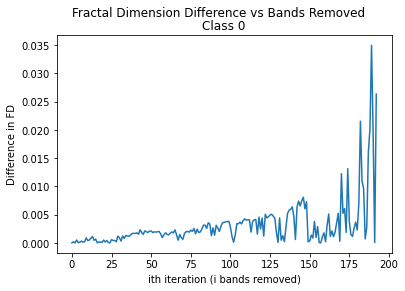

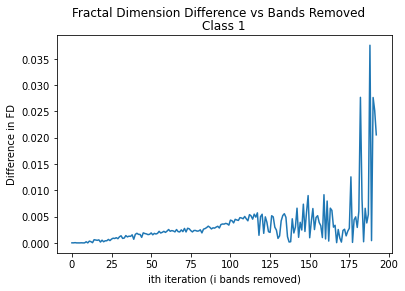

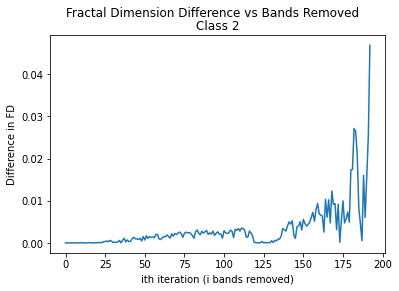

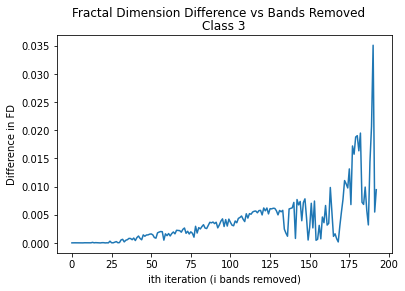

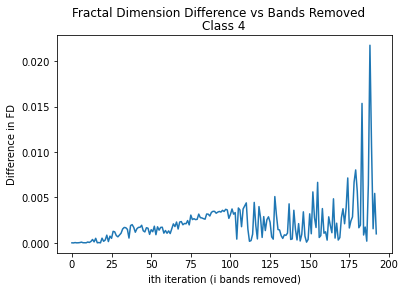

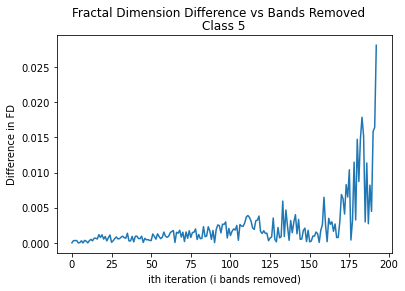

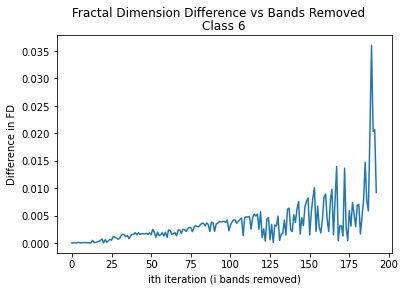

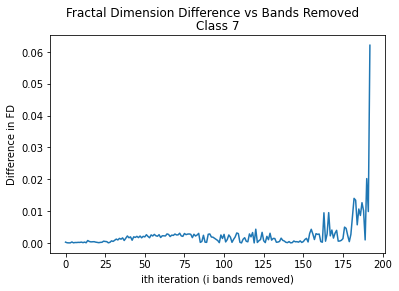

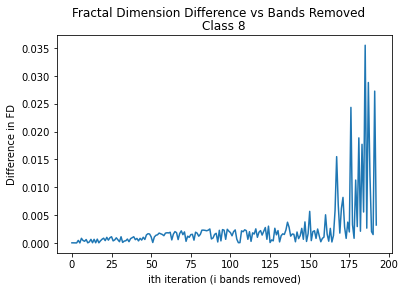

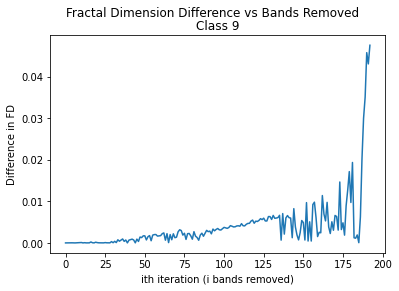

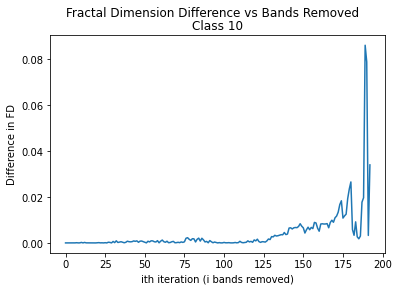

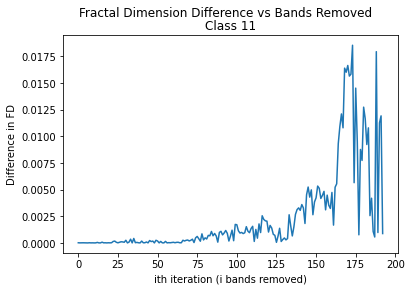

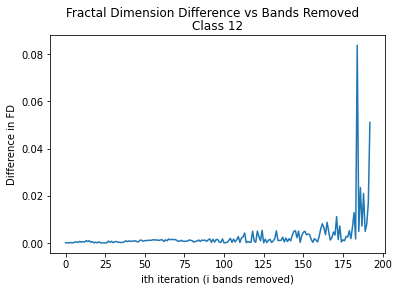

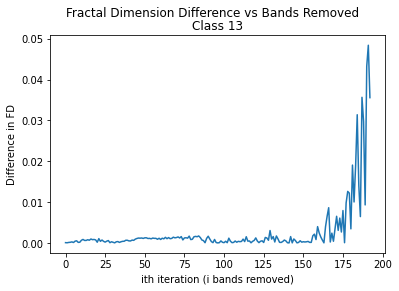

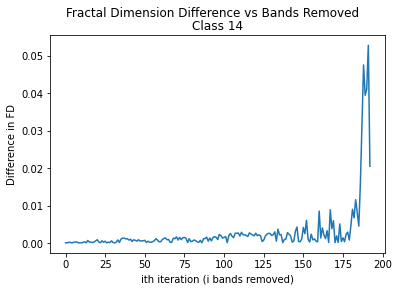

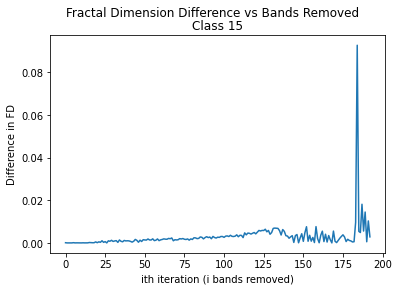

In [ ]:
#plot the differnce as function of removed bands
for i in range(len(class_dist)):

    #make an array of the min differences (change in FD) 
    min_fd = np.min(diff[:,:,i], axis=1)
    
    #plot figure
    fig = plt.figure()
    plt.plot(min_fd[:193])
    plt.title('Class ' + str(i))
    fig.suptitle('Fractal Dimension Difference vs Bands Removed')
    plt.xlabel('ith iteration (i bands removed)')
    plt.ylabel('Difference in FD')
    #save the result
    full_path = '/content/drive/My Drive/Major_Project/Test_Results2/Result1_Class' + str(i) + '.jpg'
    fig.savefig(full_path, dpi=300)

### > Smooth

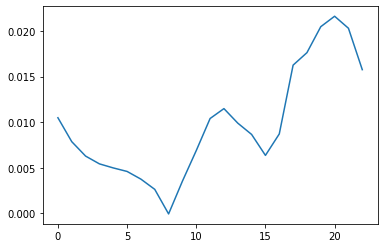

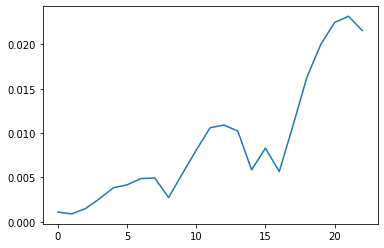

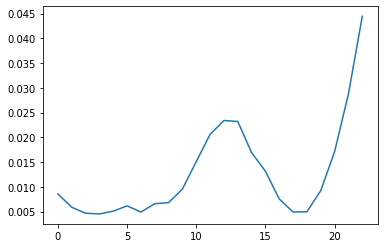

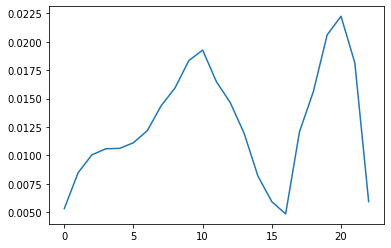

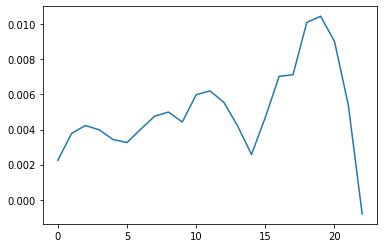

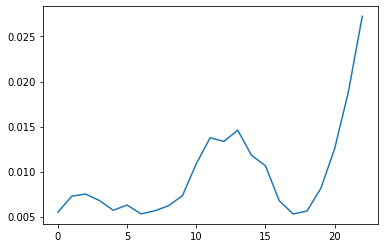

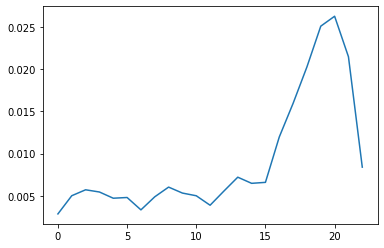

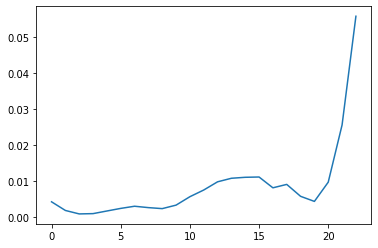

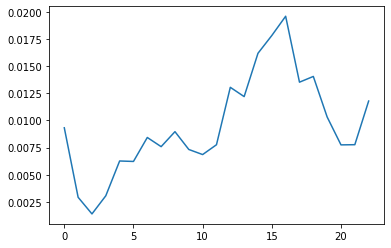

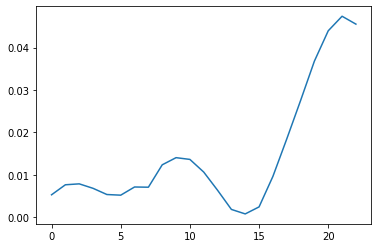

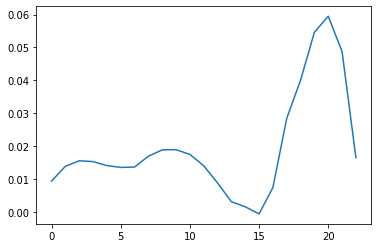

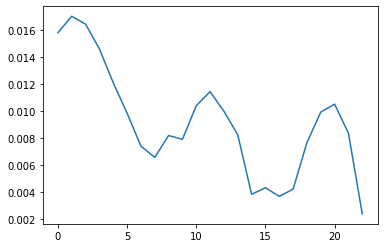

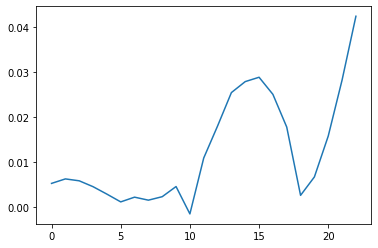

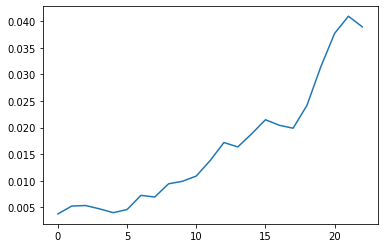

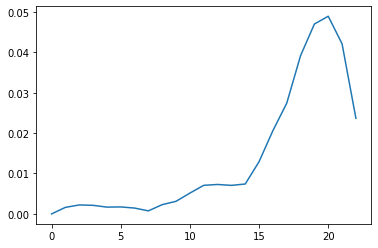

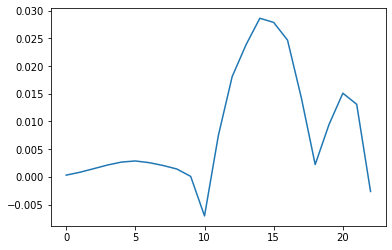

In [ ]:
for i in range(len(class_dist)):
    #make an array of the min differences (change in FD) 
    min_fd = np.min(diff[:,:,i], axis=1)

    #smooth the fractal plot over a zoomed window frame
    y = savgol_filter(min_fd[160:193], 9,3)
    #display the smoothed plot and save the results
    fig1 = plt.figure()
    plt.plot(y)
    full_path = '/content/drive/My Drive/Major_Project/Test_Results2/Result2_Class' + str(i) + '.jpg'
    fig.savefig(full_path, dpi=300)

In [ ]:
np.save('/content/drive/My Drive/Major_Project/Test_Results/reduced.npy',x)

## > Set `opt_dim`

* Take average of all classes
* Show that by inspection, we can say that it is nearly 17 for most of the classes.
* Say that it is entirely possible that different classes or different kind of pixels can indeed lead to a different optimal dimension.
* And hence, the variance in elbow position is justified.
* When sticking to this method, 
* We can take some embedding delay and embed dimension according to intuition. 
* Check if including embeding dimension helps in a better classification.


## > Main - Band Level

In [ ]:
#pick first pixel
from measures import *
x = img[img_gt!=0,:]
x = x[:2000,:]
#should be equal to number of bands
print("X shape: ", x.shape)
h = corr_dim(x, 1)
print("Original Fractal Dimesion of SRC: ", h)
#original fractal dimension for sample pixel
# for i in range(200):
#     h = corr_dim(x, 1)
#     x1 = np.delete(x, i, 1)
#     print("X shape: ", x.shape, " X1 shape: ", x1.shape)
#     h1 = corr_dim(x1, 1)
#     print("Original SRC dimension: ", x.shape)
#     print("Original Fractal Dimesion of SRC: ", h)
#     print("New Fractal Dimesion of SRC: ", h1)

X shape:  (2000, 200)
I am here
Original Fractal Dimesion of SRC:  0.005879384773500081


X shape:  (200,)
X_all shape:  (16, 200)


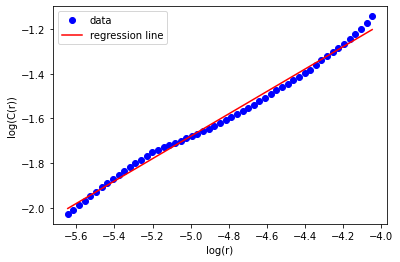

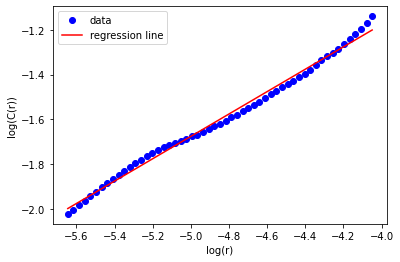

Original SRC dimension:  (200,)
Original Fractal Dimesion of SRC:  0.5020054282611301
(200,)
22
(199,)
61
(198,)
190
(197,)
127
(196,)
60
(195,)
32
(194,)
161
(193,)
110
(192,)
54
(191,)
164
(190,)
183
(189,)
65
(188,)
122
(187,)
161
(186,)
156
(185,)
160
(184,)
6
(183,)
102
(182,)
80
(181,)
119
(180,)
81
(179,)
80
(178,)
52
(177,)
31
(176,)
66
(175,)
149
(174,)
148
(173,)
147
(172,)
124
(171,)
50
(170,)
28
(169,)
163
(168,)
137
(167,)
21
(166,)
47
(165,)
47
(164,)
29
(163,)
108
(162,)
55
(161,)
54
(160,)
21
(159,)
51
(158,)
51
(157,)
51
(156,)
52
(155,)
52
(154,)
51
(153,)
19
(152,)
20
(151,)
95
(150,)
43
(149,)
0
(148,)
18
(147,)
86
(146,)
85
(145,)
89
(144,)
87
(143,)
88
(142,)
42
(141,)
41
(140,)
81
(139,)
42
(138,)
5
(137,)
10
(136,)
5
(135,)
39
(134,)
10
(133,)
109
(132,)
4
(131,)
6
(130,)
7
(129,)
5
(128,)
3
(127,)
3
(126,)
3
(125,)
1
(124,)
4
(123,)
4
(122,)
0
(121,)
2
(120,)
0
(119,)
0
(118,)
60
(117,)
44
(116,)
109
(115,)
109
(114,)
3
(113,)
3
(112,)
3
(111,)
1
(110,)
0
(109,

In [ ]:
## Main - Find optimal Dimension - Supervised

#pick first pixel
x = img[img_gt!=0,:] 
#sanity check
plt.plot(x)
#should be equal to number of bands
print("X shape: ", x.shape) 
#should be equal to [num_classes-1  x bands]
print("X_all shape: ", x_all.shape)

#original fractal dimension for sample pixel
h = nolds.corr_dim(x, 1, debug_plot=True)
x1 = np.delete(x, j)
h1 = nolds.corr_dim(x1, 1, debug_plot=True)
print("Original SRC dimension: ", x.shape)
print("Original Fractal Dimesion of SRC: ", h)

#Initialize info storing table
table = [] 
#array for the sequential FD plot - FD vs #attributes considered
FD_plot = []
#Initialize diff storing 2-D array - initialize difference storage var to 1 as to act as +inf for change in FD
diff = np.arange(bands*bands*1.0).reshape((bands, bands))*0 + 1 
#store matrix- x[i,j] denote the fractal dimension in the i'th iteration after removing the j'th band in x(updated one)
x1_matrix = np.arange(bands*bands*1.0).reshape((bands, bands))*0 + 1 
#setting optimal dimension as 5. We will inspect the plot obtained and then come here again to change the value.
opt_dim = 5
#Iterating after removal of one band with min Fractal change
for i in range(bands-opt_dim):
    #Iterating to find band with min Fractal change
    for j in range(bands-i):
        #find FD
        h = nolds.corr_dim(x, 5, fit="poly") 
        #deleting a band
        x1 = np.delete(x, j)
        #sanity check
        print("X shape: ", x.shape, " X1 shape: ", x1.shape)
        #find partial FD
        h1 = nolds.corr_dim(x1,, fit="poly")
        #find absolute difference between FD and partial FD 
        diff[i,j] = abs(h1-h) 
        #store the fractal dimension after removal of that band 
        x1_matrix[i,j] = x1

    #compute index of min difference in FD and partial FD  
    min_index_col = np.argmin(diff[i,], axis=0) 
    #Store details in info table
    table.append([ i, diff[i,min_index_col], min_index_col, x.shape])
    #store FD values of min difference column
    FD_plot[i] = x1_matrix[i, min_index_col]
    #sanity checks
    print(x.shape)
    print(min_index_col)
    #reset x after deleting band causing min change in FD or having highest correlation
    x = np.delete(x, min_index_col)

## > Results

### > Table

In [ ]:
#defining table headers
headers = ["Iteration", "Minimum fractal Diff", "Band with Min Diff", "New Shape"]
#print table
print(tabulate(table, headers, tablefmt="github"))
#save the info table in a CSV file
df = pd.DataFrame(table, columns= headers)
df.to_csv (r'/content/drive/My Drive/Major_Project/Test_Results/FD_iter.csv', index = False, header=True)

|   Iteration |   Minimum fractal Diff |   Band with Min Diff | New Shape   |
|-------------|------------------------|----------------------|-------------|
|           0 |            4.10137e-05 |                  129 | (200,)      |
|           1 |            0.000218139 |                  119 | (199,)      |
|           2 |            1.96739e-05 |                   47 | (198,)      |
|           3 |            0.000540011 |                   38 | (197,)      |
|           4 |            8.40622e-05 |                  112 | (196,)      |
|           5 |            0.00013551  |                   50 | (195,)      |
|           6 |            0.000292279 |                  137 | (194,)      |
|           7 |            1.19658e-05 |                  107 | (193,)      |
|           8 |            0.00042804  |                  191 | (192,)      |
|           9 |            0.00020809  |                   75 | (191,)      |
|          10 |            0.000880492 |                  122 | 

### > Plot

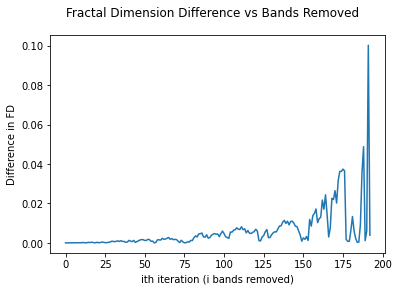

In [ ]:
#make an array of the min differences (change in FD) 
min_fd = np.min(diff, axis=1)

#plot the differnce as function of removed bands
fig = plt.figure()
plt.plot(min_fd[:193])
fig.suptitle('Fractal Dimension Difference vs Bands Removed')
plt.xlabel('ith iteration (i bands removed)')
plt.ylabel('Difference in FD')
#save the result
fig.savefig('/content/drive/My Drive/Major_Project/Test_Results/Result1.jpg',dpi=300)

### > Smooth

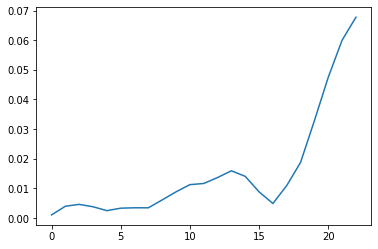

In [ ]:
#smooth the fractal plot over a zoomed window frame
y = savgol_filter(min_fd[170:193], 9,3)
#display the smoothed plot and save the results
fig1 = plt.figure()
plt.plot(y)
fig1.savefig('/content/drive/My Drive/Major_Project/Test_Results/Result2.jpg',dpi=300)

In [ ]:
np.save('/content/drive/My Drive/Major_Project/Test_Results/reduced.npy',x)